# Malaria addInputEIR calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity

### In this version, we will be utilizing the full immune parameter space, sampling also which immune forces should be included in the calculation of the immune modifier (ie configurable params starting with "Immune_Modifier_Include*"

### For iter0 we will cut down parameter space by using the distribution of malaria prevalence by season, age and density bins from a moderate high transmission setting in Sugungum, Garki, Nigeria

# Import block

In [1]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

from wand.image import Image as WImage
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

import pycuda
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis
sns.set(font_scale=2)
sns.set_style("white")

C:\conda\envs\history_matching\lib\site-packages\skcuda\cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [3]:
site = 'Sugungum'
season_cut = 'W2'
age_bin_cut = 8
density_bin_cut = 500

cut_name = f'{density_bin_cut}_{age_bin_cut}_{season_cut}_{site}'

#iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 2

#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['7d95a4cd-dd60-ea11-a2c5-c4346bcb1550'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Garki_df.csv')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_c686920dee8501a26fe576ed61915351.hd5


,Min,Max,MapTo
Name,,,
Biological_Age_Immune_Coefficient_PPP,0.0,10,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,0.0,1,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0.0,10,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,0.0,1,Cumulative_Exposure_Immune_Coefficient_TM
Scale_Factor_Age_a,3.0,5,Scale_Factor_Age_a
Parasite_Density_Wave_Sigma,0.6,6,Parasite_Density_Wave_Sigma
Immune_Modifier_Include_Age,0.0,1,Immune_Modifier_Include_Age
Immune_Modifier_Include_Cumulative_Exposure,0.0,1,Immune_Modifier_Include_Cumulative_Exposure


## Read in Sim Results

In [6]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'full_analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    
    sr = sr[(sr.season == season_cut)&(sr.age_bin ==age_bin_cut)&(sr.density_bin==density_bin_cut)]
    print(sr.head())
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results.csv')
results = all_results['Result']

results = all_results \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)
print(type(results))
display(results.head())

-------------------------------------------------------------------------------- 
Experiment: 7d95a4cd-dd60-ea11-a2c5-c4346bcb1550
7d95a4cd-dd60-ea11-a2c5-c4346bcb1550\full_analyzer_results.csv
     Unnamed: 0  sample                                sim_id season  age_bin  \
51            0       0  ddcdb4d3-dd60-ea11-a2c5-c4346bcb1550     W2        8   
114           0      15  eccdb4d3-dd60-ea11-a2c5-c4346bcb1550     W2        8   
177           0      39  12ceb4d3-dd60-ea11-a2c5-c4346bcb1550     W2        8   
240           0       6  e3cdb4d3-dd60-ea11-a2c5-c4346bcb1550     W2        8   
303           0      41  fbcdb4d3-dd60-ea11-a2c5-c4346bcb1550     W2        8   

     density_bin     value  
51           500  0.100363  
114          500  0.057128  
177          500  0.139272  
240          500  0.133271  
303          500  0.060169  
<class 'pandas.core.frame.DataFrame'>


,,Sim_Result
Sample_Id,Sim_Id,
7d95a4cd-dd60-ea11-a2c5-c4346bcb1550.000000,ddcdb4d3-dd60-ea11-a2c5-c4346bcb1550,0.100363
7d95a4cd-dd60-ea11-a2c5-c4346bcb1550.000001,decdb4d3-dd60-ea11-a2c5-c4346bcb1550,0.080972
7d95a4cd-dd60-ea11-a2c5-c4346bcb1550.000002,dfcdb4d3-dd60-ea11-a2c5-c4346bcb1550,0.062837
7d95a4cd-dd60-ea11-a2c5-c4346bcb1550.000003,e0cdb4d3-dd60-ea11-a2c5-c4346bcb1550,0.049505
7d95a4cd-dd60-ea11-a2c5-c4346bcb1550.000004,e1cdb4d3-dd60-ea11-a2c5-c4346bcb1550,0.074647


In [7]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [8]:
ref_data_path = os.path.join('..','reference data','Garki_df.csv')
df = pd.read_csv(ref_data_path)

self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, np.inf],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [0, 1, 4, 8, 18, 28, 43, np.inf],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

# how to set the cwd
ref_data =dftemp
ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
ref_data = ref_data[ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin']

new_ref_df = pd.DataFrame()
for i, grouping in ref_data.groupby(by=['Channel', 'Season', 'Age Bin']):
    group_subset = pd.DataFrame()
    
    low = grouping[grouping['PfPR Bin'] == 50]
    low.proportion += grouping[grouping['PfPR Bin'] == 0]['proportion'].values[0]
        
    middle = grouping[grouping['PfPR Bin'] == 500]
    middle.proportion += grouping[grouping['PfPR Bin'] == 200]['proportion'].values[0]
    
    high = grouping[grouping['PfPR Bin'] == np.inf]
    new_ref_df = pd.concat([new_ref_df,low,middle,high])
new_ref_df.drop('Counts',axis = 1, inplace=True)    
new_ref_df = new_ref_df[(new_ref_df.Season == season_cut) & (new_ref_df['Age Bin'] == age_bin_cut) & (new_ref_df['PfPR Bin'] == density_bin_cut)]
new_ref_df['binomial error'] = np.sqrt((new_ref_df['proportion']*(1-new_ref_df['proportion']))/new_ref_df['bin_pop'])
print(new_ref_df)
mean = new_ref_df.proportion
error = new_ref_df['binomial error']


desired_result = mean.values[0]
desired_result_std = error.values[0]

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


C:\conda\envs\history_matching\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\conda\envs\history_matching\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                             Channel Season Age Bin  PfPR Bin  bin_pop  \
188  PfPR by Parasitemia and Age Bin     W2     8.0     500.0    162.0   

     proportion  binomial error  
188    0.487654        0.039272  
Before logit, desired result is 0.488 [0.409, 0.566]: 


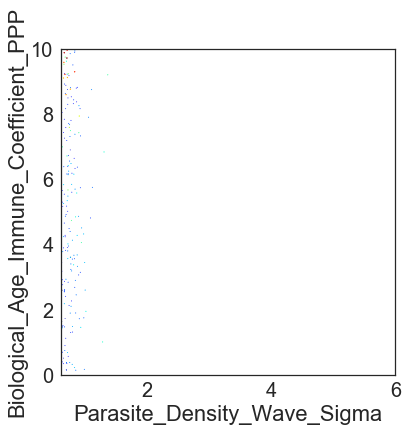

In [9]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Parasite_Density_Wave_Sigma',	'Biological_Age_Immune_Coefficient_PPP'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=5*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [10]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
print(type(results))
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

<class 'pandas.core.frame.DataFrame'>
Welcome to IDM History Matching!
Found 200 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 150 unique parameter configurations ( 150  simulations including replicates)
--> Testing  with 50  unique parameter configurations ( 50 simulations including replicates)


Found existing GLM basis with the following terms:


[Term([]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_PPP')]),
 Term([EvalFactor('Immune_Modifier_Include_Age')])]

Would you like to use this basis? [Y]/n: n
Regularize:  0  of  15
Regularize:  1  of  15
Regularize:  2  of  15
Regularize:  3  of  15
Regularize:  4  of  15
Regularize:  5  of  15
Regularize:  6  of  15
Regularize:  7  of  15
Regularize:  8  of  15
Regularize:  9  of  15
Regularize:  10  of  15
Regularize:  11  of  15
Regularize:  12  of  15
Regularize:  13  of  15
Regularize:  14  of  15


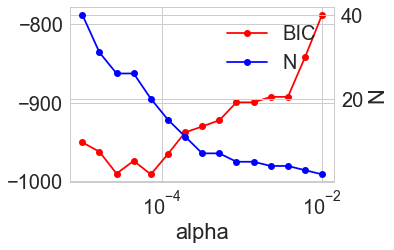

What would you like to use for the GLM regularization parameter, alpha_glm = 1e-4
User selected alpha = 0.000100
Non-Zero: 18 of 45
Regularization for GLM selected:
  * Intercept
 * Biological_Age_Immune_Coefficient_PPP
 * Biological_Age_Immune_Coefficient_TM
 * Parasite_Density_Wave_Sigma
 * Immune_Modifier_Include_Cumulative_Exposure
 * Biological_Age_Immune_Coefficient_PPP ** 2
 * Cumulative_Exposure_Immune_Coefficient_PPP ** 2
 * Immune_Modifier_Include_Cumulative_Exposure ** 2
 * Biological_Age_Immune_Coefficient_PPP * Cumulative_Exposure_Immune_Coefficient_PPP
 * Biological_Age_Immune_Coefficient_PPP * Scale_Factor_Age_a
 * Biological_Age_Immune_Coefficient_PPP * Immune_Modifier_Include_Age
 * Biological_Age_Immune_Coefficient_PPP * Immune_Modifier_Include_Cumulative_Exposure
 * Biological_Age_Immune_Coefficient_TM * Cumulative_Exposure_Immune_Coefficient_PPP
 * Biological_Age_Immune_Coefficient_TM * Cumulative_Exposure_Immune_Coefficient_TM
 * Biological_Age_Immune_Coefficient_T

In [11]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

    basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

In [12]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 1000,
    plot = True, #force_optimize_glm,
    plot_data = True
)

Generalized Linear Modeling
Plotting


In [13]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [14]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter2\Cuts\500_8_W2_Sugungum\GLM\GLM Predicted vs Actual.svg


In [15]:
basis_gpr = Basis.polynomial_basis(
#     params =  [
# 'Scale_Factor_Age_a', 
# 'Cumulative_Exposure_Immune_Coefficient_TM',
# 'Recent_Exposure_Immune_Coefficient_PPP',
# 'Recent_Exposure_Immune_Coefficient_TM',
# 'Parasite_Density_Wave_Sigma',
# 'Immune_Modifier_Include_Age',
# 'Immune_Modifier_Include_Strain_Diversity',
# 'Immune_Modifier_Include_Cumulative_Exposure'
#               ],
    params = param_info.index.values, 
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [16]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [7.49636161e+01 4.30910765e-02 2.18296911e+01 8.08185597e+01
#  5.86791240e-02 4.55925184e+01 7.61216580e+01 3.72424498e-01
#  9.24611775e-01 7.41104089e-01]
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Backing up gpr model to ..\iter2\Cuts\500_8_W2_Sugungum\GPR\model_2020_03_07_17_58_42.json
Fitting the GPR

	LL: 234.06933705918493 
	Theta: [0.6  2.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25] 
	Deriv: [ 5.47923149e+00  1.80026655e+01 -1.48426170e+00 -5.03437878e+00
  2.37242673e+00 -1.33068497e+00 -5.24646822e+00  1.48879063e-02
  4.09392537e+00 -1.23232082e-01]

	LL: 2759.086311762841 
	Theta: [0.1        0.01       1.7342617  5.28437878 0.01       1.58068497
 5.49646822 0.23511209 0.01       0.37323208] 
	Deriv: [-8.59851622e+03 -1.97311887e+05  1.91019711e+02  1.25224652e+01
  5.55545162e+04  5.26093318e+01  1.74844252e+01  1.73283923e+02
  5.77802582e+04  3.95223203e+02]

	LL: 215.32869038069725 
	Theta: [0.42987343 1.32289624 0.75502472 1.96296323 0.16833924 0.70276975
 2.03512733 0.24493434 0.16833924 0.2919301 ] 
	Deriv: [-1.97304785 18.6147915  -0.1535952  -0.26704803 16.42844129 -0.21621426
 -0.29343904  0.08186373  8.62084782  0.18003888]

	LL: 11


	LL: 265.4107524438865 
	Theta: [4.36926176 0.01       0.01       0.01       0.01       0.01
 0.01       0.17573616 0.01       0.01      ] 
	Deriv: [ 1.31911376e+01  1.33419810e+01 -2.76405024e+01 -2.07266637e+01
 -1.77420166e+01 -1.85346807e+01 -1.08594485e+01 -7.04966246e-03
 -6.96615254e+00 -1.14631794e+01]

	LL: 195.78907619511673 
	Theta: [1.15820314 0.44275426 0.57622452 1.66468325 0.01       0.60033159
 1.72013749 0.2265541  0.01       0.19413323] 
	Deriv: [ 3.80640251e-01 -3.57529954e+00  7.73287078e+00 -1.10713029e+00
  2.56667250e+02 -2.18605358e-01 -2.15015488e-02  6.47893587e-01
  1.71250323e+02  5.10930893e+00]

	LL: 230.41399789608417 
	Theta: [2.19063395 0.04659416 0.01       0.03402121 0.01       0.18090102
 0.01       0.20518819 0.01       0.01      ] 
	Deriv: [ 1.84506946e+01  1.94168778e+01 -9.34972382e+01 -2.14177896e+01
 -5.22915686e+01 -6.17988246e-01 -5.67835178e+01 -2.16938498e-02
 -3.44738170e+01 -4.01047970e+01]

	LL: 195.4892241046373 
	Theta: [1.42423079 0.


	LL: 199.6456027215691 
	Theta: [1.47282065 0.01       0.1859008  0.35930401 0.01130058 0.01
 0.49752655 0.01       0.01207409 0.02332239] 
	Deriv: [   8.77569843    6.38801388    4.19140874  -11.47164218  -47.41574756
 -615.60785556   -2.88761147  147.8804158  -253.04327855  212.24194115]

	LL: 188.2834493561977 
	Theta: [1.20695608 0.09411641 0.14472542 0.35788644 0.01574393 0.2501423
 0.38639734 0.01       0.01073019 0.01561037] 
	Deriv: [   1.68003753   -2.60950889   12.18345581   -6.74881769  -95.11738192
    3.87930354   -3.63175819   74.72970393 -109.00449912  124.60000271]

	LL: 196.65341816461506 
	Theta: [1.29122997 0.03812782 0.15536168 0.33854211 0.01474146 0.01
 0.41101148 0.01       0.01182302 0.01265298] 
	Deriv: [  10.17034812   18.9479698    -1.25169326  -12.84494613    3.23260284
 -750.9825781    -4.12442614   81.76506616 -282.64768693  136.0423437 ]

	LL: 187.9096646504566 
	Theta: [1.23553858 0.07512721 0.14833284 0.35132558 0.01540393 0.16869517
 0.39474552 0.01  


	LL: 174.15928995195458 
	Theta: [4.5356824  0.14523363 0.46162098 2.4885112  0.05559357 0.4819789
 1.99437663 0.01       0.09340028 0.02933599] 
	Deriv: [-2.56916747e+00 -1.42925171e+01  1.12567744e+01 -2.51909411e-01
  3.62772843e+01 -1.66911937e+00  1.44244214e-01  3.31170738e+02
  4.54643264e+01  1.20225127e+02]

	LL: 172.62714947129282 
	Theta: [5.66845082 0.13809857 0.54564507 3.38565721 0.0451425  0.66903625
 2.57065855 0.01       0.07975354 0.02480442] 
	Deriv: [-9.81523021e-01  4.04001928e+00  1.06814215e+01 -7.01089947e-02
 -5.48589551e+01 -7.54502309e-01 -5.17884541e-02  2.41567913e+02
 -2.24117264e+01 -1.01647426e+02]

	LL: 171.89548319369294 
	Theta: [6.47884654 0.15017583 0.61611282 3.87261755 0.0521671  0.76992642
 2.94558373 0.01       0.09436185 0.02843624] 
	Deriv: [-1.27416218e+00  5.80171430e+00  1.14948179e+01 -5.46366467e-02
 -2.96271840e+01 -7.16905955e-01  8.63914920e-02  2.45839761e+02
  1.40988669e+01 -2.12167468e+01]

	LL: 171.47299613665498 
	Theta: [7.4090


	LL: 163.69444693776458 
	Theta: [1.08404464e+02 1.61526857e-01 1.37939558e+00 6.89218451e+01
 1.48907371e-01 1.00805060e+01 4.97936383e+01 1.73206653e-02
 1.96416960e-01 7.95311005e-02] 
	Deriv: [-0.02515176 -5.2546894   0.34747082  0.02215496  1.1075159  -0.14365637
  0.03146846 11.17841995  3.60264027 11.79820045]

	LL: 163.66354269971953 
	Theta: [1.15934787e+02 1.63409559e-01 1.40417339e+00 7.37342372e+01
 1.54149505e-01 1.07493158e+01 5.32504933e+01 1.83512787e-02
 1.97550646e-01 8.03396162e-02] 
	Deriv: [-0.02245388 -4.19682677  0.26226455  0.02071215  2.85818174 -0.13321033
  0.02886784  8.73791743  2.24124655  9.32998591]

	LL: 163.6099998516003 
	Theta: [1.30905549e+02 1.66075969e-01 1.43787698e+00 8.33017644e+01
 1.60734800e-01 1.20681352e+01 6.01201579e+01 2.13041227e-02
 2.01275725e-01 7.85794190e-02] 
	Deriv: [-0.01699444 -1.06361164  0.16655889  0.01873573  3.48229596 -0.12046169
  0.02497639  4.49845862  0.02639165  0.84359347]

	LL: 163.59002113898782 
	Theta: [1.4309


	LL: 159.5789509672573 
	Theta: [6.12068684e+02 1.31031122e-01 3.09472628e+00 9.23636000e+01
 2.60664631e-01 5.48104903e+01 3.36166720e+01 3.82192666e-02
 3.32326628e-01 8.59484621e-02] 
	Deriv: [-7.74383283e-04 -2.83306709e-01  4.32553640e-01  2.84765091e-03
 -1.55231230e+00 -1.22533522e-02  4.15623675e-03 -1.07371671e-01
 -5.71194666e-01  9.18929079e-01]

	LL: 159.5458451013581 
	Theta: [6.67199688e+02 1.30006184e-01 3.20847023e+00 1.00000000e+02
 2.69362325e-01 5.96649177e+01 3.48553770e+01 3.72455901e-02
 3.37823535e-01 8.78914337e-02] 
	Deriv: [-6.27461523e-04 -1.09595156e+00  4.19957533e-01  2.66507268e-03
 -1.45972978e+00 -9.86907092e-03  5.61966945e-03 -1.12059184e+00
 -1.36124627e+00  1.16687790e+00]

	LL: 159.5038206488015 
	Theta: [7.95297057e+02 1.40193924e-01 3.29408038e+00 1.00000000e+02
 2.84571751e-01 7.08363634e+01 4.37175986e+01 4.94751193e-02
 3.54311639e-01 8.90309774e-02] 
	Deriv: [ 4.43698129e-05  9.63284346e+00  2.17693862e-01  1.43368993e-03
 -1.27939885e+00 -8


	LL: 159.35740557756475 
	Theta: [1.00000000e+03 1.31946840e-01 3.62475477e+00 1.00000000e+02
 3.21422476e-01 9.04259515e+01 3.98388141e+01 5.28393215e-02
 3.80374121e-01 9.20951694e-02] 
	Deriv: [-1.74063977e-04 -3.01331346e+00  1.33690046e-01 -1.31152540e-03
  2.19197955e+00 -4.99016859e-03  1.59916566e-03  1.95255867e+00
  1.40371348e-01 -1.31471295e+00]

	LL: 159.35740557756475 
	Theta: [1.00000000e+03 1.31946840e-01 3.62475477e+00 1.00000000e+02
 3.21422476e-01 9.04259515e+01 3.98388141e+01 5.28393215e-02
 3.80374121e-01 9.20951694e-02] 
	Deriv: [-1.74063977e-04 -3.01331346e+00  1.33690046e-01 -1.31152540e-03
  2.19197955e+00 -4.99016859e-03  1.59916566e-03  1.95255867e+00
  1.40371348e-01 -1.31471295e+00]

	LL: 159.35740557756475 
	Theta: [1.00000000e+03 1.31946840e-01 3.62475477e+00 1.00000000e+02
 3.21422476e-01 9.04259515e+01 3.98388141e+01 5.28393215e-02
 3.80374121e-01 9.20951694e-02] 
	Deriv: [-1.74063977e-04 -3.01331346e+00  1.33690164e-01 -1.31152540e-03
  2.19196562e+00

c:\git\history_matching\history_matching\gpr.py:1124: RuntimeWarning: invalid value encountered in sqrt
  train['Z_Score'] = (train[self.Ycol_orig] - train[mean_col]) / np.sqrt(train[var_col])
c:\git\history_matching\history_matching\gpr.py:1125: RuntimeWarning: invalid value encountered in sqrt
  test['Z_Score'] = (test[self.Ycol_orig] - test[mean_col]) / np.sqrt(test[var_col])
c:\git\history_matching\history_matching\gpr.py:1129: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(x=test[self.Ycol_orig], y=test[mean_col], yerr=2*np.sqrt(test[var_col]), fmt='o', c='m', lw=0.5)
c:\git\history_matching\history_matching\gpr.py:1130: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(x=train[self.Ycol_orig], y=train[mean_col], yerr=2*np.sqrt(train[var_col]), fmt='o', c='c', lw=0.5)
C:\conda\envs\history_matching\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 

In [17]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                                          Name  Lengthscale
5                  Parasite_Density_Wave_Sigma     0.052342
7  Immune_Modifier_Include_Cumulative_Exposure     0.093174
2   Cumulative_Exposure_Immune_Coefficient_PPP     0.320136
6                  Immune_Modifier_Include_Age     0.380215
0        Biological_Age_Immune_Coefficient_PPP     3.624599
4                           Scale_Factor_Age_a    39.838813
3    Cumulative_Exposure_Immune_Coefficient_TM    90.425957
1         Biological_Age_Immune_Coefficient_TM   100.000000


In [18]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [19]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility


c:\git\history_matching\history_matching\HistoryMatching.py:538: RuntimeWarning: invalid value encountered in sqrt
  self.training_data['Z_Noisy'] = (self.training_data[self.Ycol] - self.training_data['Mean_Estimate']) / np.sqrt(self.training_data['Var_Err_Predictive'])
c:\git\history_matching\history_matching\HistoryMatching.py:539: RuntimeWarning: invalid value encountered in sqrt
  self.training_data['Z_Noiseless'] = (self.training_data[self.Ycol] - self.training_data['Mean_Estimate']) / np.sqrt(self.training_data['Var_Err_Latent'])


Good


In [20]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter2\Cuts\500_8_W2_Sugungum\Implausibility\implausibility.svg


In [21]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());

KeyError: 'AgeBin'